### Results for Inflation Forecast 

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sqlite3
from scipy.stats import norm
import pickle
import os

database_name = 'database_predict_inflation.db'
con = sqlite3.connect(os.path.join('Results', database_name))
cur = con.cursor()

# Transformation = 'No Transform'
Transformation = 'Transform'

Target = 'Inflation'
num_lags = 2
# Target = 'Inflation MoM'
# num_lags = 1


Window_size = 534
Validation_size = 113
seed_list = [42, 43, 44, 45, 46]

In [92]:
forcast_start = pd.to_datetime('2015-01-01')
Models = ['Random Walk','AR1', 'AR12','AR','AR1_12','RA',
          'Random Forest','XGBoost','XGBoost-subsample','Ridge',
          'LASSO','ADALASSO','PCR','RKHS','NN']
RMSE = {}
params = {}
rolling_RMSE = {}
for seed in seed_list:
    for i, model in enumerate(Models):
        query = """SELECT * FROM RESULTS WHERE model='%s' and seed=%i and Transformation='%s' and Target='%s'""" %(model,seed,Transformation,Target)
        RESULTS = pd.read_sql(query, con)
        date_idx = forcast_start<=pd.to_datetime(RESULTS.Date)
        forecast_date = RESULTS.Date[date_idx]
        n_test = np.sum(date_idx)
        test_err = RESULTS.loc[date_idx,:].Value - RESULTS.loc[date_idx,:].Prediction
        RMSE[model,seed] = np.sqrt(np.mean((test_err)**2))
        params[model,seed] = np.unique(RESULTS.Parameter)[0]
        rolling_RMSE[model,seed] = np.zeros((n_test-24,))
        for j in range(n_test-24):
            rolling_RMSE[model,seed][j] = np.sqrt(np.sum(test_err[j:j+24]**2)/24)


In [93]:
RESULTS

,Date,Target,Value,Prediction,Model,Seed,Parameter,Window_size,Validation_size,Transformation
0,01/01/2015,Inflation,-0.002302,0.348558,NN,46,24,535,113,Transform
1,02/01/2015,Inflation,-0.000871,0.440119,NN,46,24,535,113,Transform
2,03/01/2015,Inflation,-0.000220,0.901773,NN,46,24,535,113,Transform
3,04/01/2015,Inflation,-0.001041,0.086432,NN,46,24,535,113,Transform
4,05/01/2015,Inflation,0.000350,0.107475,NN,46,24,535,113,Transform
...,...,...,...,...,...,...,...,...,...,...
108,01/01/2024,Inflation,0.030587,0.142039,NN,46,24,535,113,Transform
109,02/01/2024,Inflation,0.031167,-0.344404,NN,46,24,535,113,Transform
110,03/01/2024,Inflation,0.034161,2.526904,NN,46,24,535,113,Transform
111,04/01/2024,Inflation,0.033026,1.448334,NN,46,24,535,113,Transform


In [94]:
RMSE_pd = pd.Series(RMSE).reset_index()
RMSE_pd.columns = ['Model','seed','values']
RESULTS = RMSE_pd.pivot(index=['seed'], columns='Model', values='values')
seed_depend = ['Random Forest', 'XGBoost-subsample', 'NN']
seed_nodepend = ['Random Walk','AR1','AR12','AR1_12','AR','RA','Ridge','LASSO','ADALASSO', 'PCR', 'RKHS', 'XGBoost']
temp = RESULTS.index.astype(str)
RESULTS.index = 'seed='+temp 
with pd.option_context('display.precision', 5):
    display(RESULTS[seed_depend])
    display(RESULTS[seed_nodepend])


Model,Random Forest,XGBoost-subsample,NN
seed,,,
seed=42,0.00511,0.00968,1.02005
seed=43,0.00529,0.01190,2.77736
seed=44,0.00526,0.01056,2.51148
seed=45,0.00518,0.00970,2.44344
seed=46,0.00521,0.00932,2.05920


Model,Random Walk,AR1,AR12,AR1_12,AR,RA,Ridge,LASSO,ADALASSO,PCR,RKHS,XGBoost
seed,,,,,,,,,,,,
seed=42,0.00388,0.00386,0.00355,0.00364,0.00342,0.00388,0.00516,0.00382,0.00367,0.00545,0.0189,0.00671
seed=43,0.00388,0.00386,0.00355,0.00364,0.00342,0.00388,0.00516,0.00382,0.00367,0.00545,0.0189,0.00671
seed=44,0.00388,0.00386,0.00355,0.00364,0.00342,0.00388,0.00516,0.00382,0.00367,0.00545,0.0189,0.00671
seed=45,0.00388,0.00386,0.00355,0.00364,0.00342,0.00388,0.00516,0.00382,0.00367,0.00545,0.0189,0.00671
seed=46,0.00388,0.00386,0.00355,0.00364,0.00342,0.00388,0.00516,0.00382,0.00367,0.00545,0.0189,0.00671


In [95]:
params_pd = pd.Series(params).reset_index()
params_pd.columns = ['Model','seed','values']
RESULTS = params_pd.pivot(index=['seed'], columns='Model', values='values')
seed_depend = ['Random Forest', 'XGBoost-subsample', 'NN']
seed_nodepend = ['Random Walk','AR1','AR12','AR1_12','AR','RA','Ridge','LASSO','ADALASSO', 'PCR', 'RKHS', 'XGBoost']
temp = RESULTS.index.astype(str)
RESULTS.index = 'seed='+temp 
with pd.option_context('display.precision', 5):
    display(RESULTS[seed_depend])
    display(RESULTS[seed_nodepend])

Model,Random Forest,XGBoost-subsample,NN
seed,,,
seed=42,16,12,35
seed=43,6,50,1
seed=44,6,21,8
seed=45,13,12,17
seed=46,6,12,24


Model,Random Walk,AR1,AR12,AR1_12,AR,RA,Ridge,LASSO,ADALASSO,PCR,RKHS,XGBoost
seed,,,,,,,,,,,,
seed=42,,,,,2,1,689.6551724137931,0.00020689655172493102,5.9183673877551016e-08,97,1e-15,21
seed=43,,,,,2,1,689.6551724137931,0.00020689655172493102,5.9183673877551016e-08,97,1e-15,21
seed=44,,,,,2,1,689.6551724137931,0.00020689655172493102,5.9183673877551016e-08,97,1e-15,21
seed=45,,,,,2,1,689.6551724137931,0.00020689655172493102,5.9183673877551016e-08,97,1e-15,21
seed=46,,,,,2,1,689.6551724137931,0.00020689655172493102,5.9183673877551016e-08,97,1e-15,21


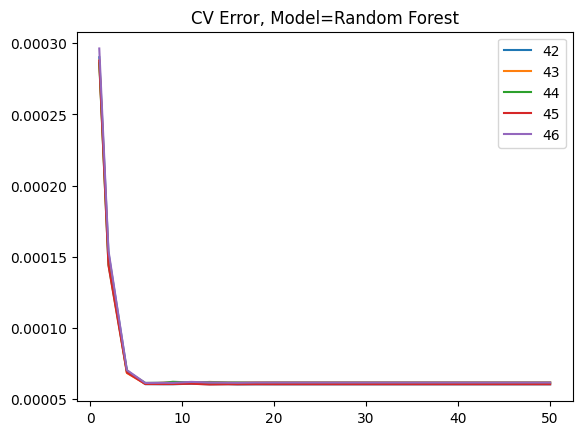

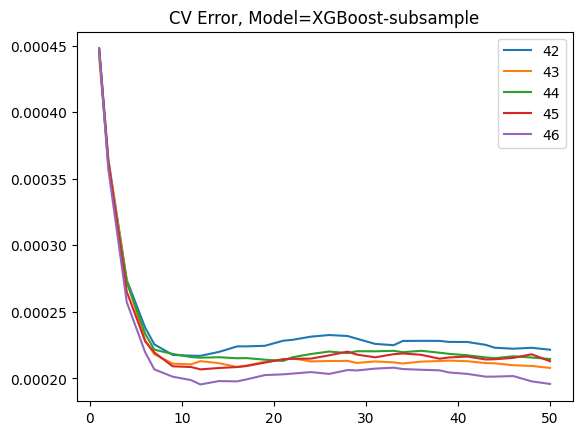

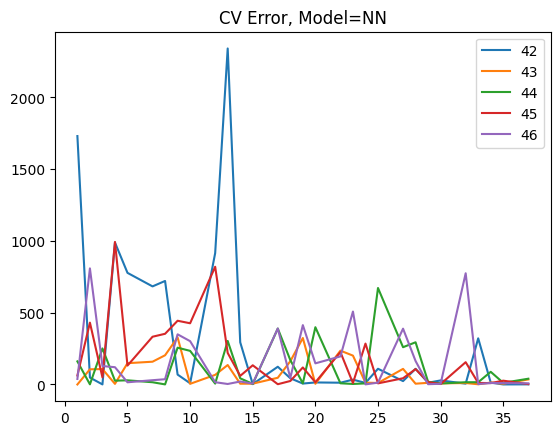

In [96]:
Models_seed_depend = ['Random Forest','XGBoost-subsample','NN']

for i, model in enumerate(Models_seed_depend):
    query = """SELECT * FROM CV_error WHERE model='%s' and
    Transformation='%s' and Target='%s'""" %(model,Transformation,Target)
    RESULTS = pd.read_sql(query, con)
    idx = RESULTS.Tune_Param == 'CV_grid'
    grid = RESULTS[idx].iloc[0,7:].values
    val = RESULTS[~idx]
    legend_used = val.Seed
    val_used = val.iloc[:,7:].values.T
    if np.isin('None', grid):
            grid = [None if x=='None' else x for x in grid]
    plt.plot(grid,val_used)
    plt.legend(legend_used)
    plt.title('CV Error, Model=%s'%model)
    plt.show()


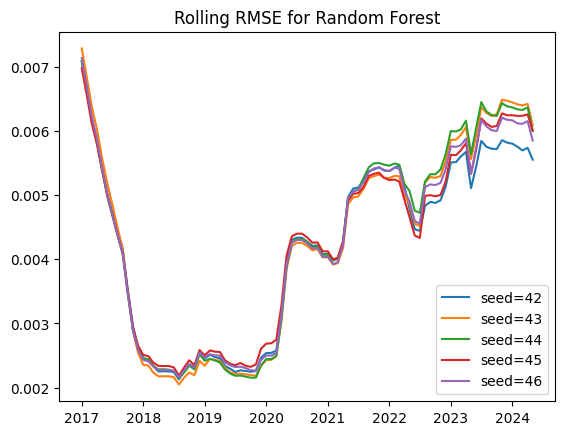

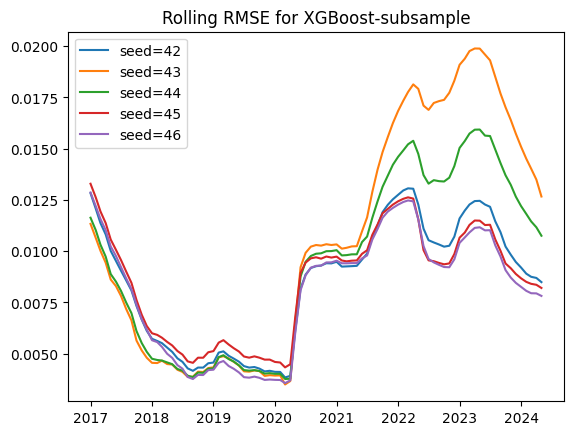

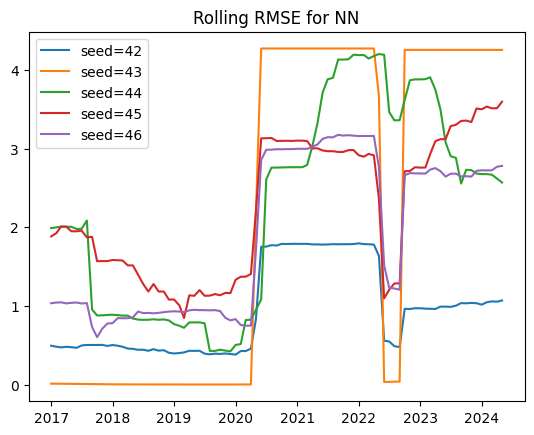

In [97]:
rolling_RMSE_pd = pd.Series(rolling_RMSE).reset_index()
rolling_RMSE_pd.columns = ['Model','seed','values']

for sd_md in seed_depend:
    plt.plot(pd.to_datetime(forecast_date[24:]),np.vstack(rolling_RMSE_pd.query("Model=='%s'"%sd_md)['values']).T)
    plt.title('Rolling RMSE for %s'%sd_md)
    plt.legend(['seed=%i'%sd for sd in seed_list])
    plt.show()


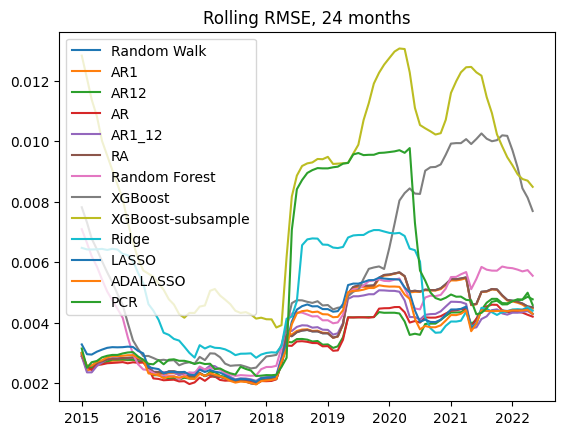

In [98]:
seed = 42
query_rst = rolling_RMSE_pd.query("seed==%i and Model!='NN' and Model!='RKHS'"%seed)

plt.plot(pd.to_datetime(forecast_date[:-24]),np.vstack(query_rst['values']).T)
plt.legend(query_rst['Model'])
plt.title('Rolling RMSE, 24 months')
plt.show()

Partially Linear Models

In [99]:
forcast_start = pd.to_datetime('2015-01-01')
Models = ['Random Forest','XGBoost','XGBoost-subsample','PCR','PCRp','RKHS','NN']
Models = [nm+'-PL-%ilags'%num_lags for nm in Models]
Models = np.append(Models,'AR')
RMSE = {}
params = {}
rolling_RMSE = {}
for seed in seed_list:
    for i, model in enumerate(Models):
        query = """SELECT * FROM RESULTS WHERE model='%s' and seed=%i and Transformation='%s' and Target='%s'""" %(model,seed,Transformation,Target)
        RESULTS = pd.read_sql(query, con)
        date_idx = forcast_start<=pd.to_datetime(RESULTS.Date)
        forecast_date = RESULTS.Date[date_idx]
        n_test = np.sum(date_idx)
        test_err = RESULTS.loc[date_idx,:].Value - RESULTS.loc[date_idx,:].Prediction
        RMSE[model,seed] = np.sqrt(np.mean((test_err)**2))
        params[model,seed] = np.unique(RESULTS.Parameter)[0]
        rolling_RMSE[model,seed] = np.zeros((n_test-24,))
        for j in range(n_test-24):
            rolling_RMSE[model,seed][j] = np.sqrt(np.sum(test_err[j:j+24]**2)/24)


In [100]:
RMSE_pd = pd.Series(RMSE).reset_index()
RMSE_pd.columns = ['Model','seed','values']
RMSE_pd
RESULTS = RMSE_pd.pivot(index=['seed'], columns='Model', values='values')
seed_depend = ['Random Forest', 'XGBoost-subsample', 'NN']
seed_depend = [nm+'-PL-%ilags'%num_lags for nm in seed_depend]

seed_nodepend = ['PCR','PCRp', 'RKHS', 'XGBoost']
seed_nodepend = [nm+'-PL-%ilags'%num_lags for nm in seed_nodepend]
seed_nodepend = np.append(seed_nodepend,'AR')
temp = RESULTS.index.astype(str)
RESULTS.index = 'seed='+temp 
with pd.option_context('display.precision', 5):
    display(RESULTS[seed_depend])
    display(RESULTS[seed_nodepend])

Model,Random Forest-PL-2lags,XGBoost-subsample-PL-2lags,NN-PL-2lags
seed,,,
seed=42,0.00361,0.00340,1.86297
seed=43,0.00345,0.00344,0.83005
seed=44,0.00352,0.00341,2.17901
seed=45,0.00347,0.00344,1.48235
seed=46,0.00347,0.00343,2.90874


Model,PCR-PL-2lags,PCRp-PL-2lags,RKHS-PL-2lags,XGBoost-PL-2lags,AR
seed,,,,,
seed=42,0.00359,0.00308,0.00342,0.00345,0.00342
seed=43,0.00359,0.00308,0.00342,0.00345,0.00342
seed=44,0.00359,0.00308,0.00342,0.00345,0.00342
seed=45,0.00359,0.00308,0.00342,0.00345,0.00342
seed=46,0.00359,0.00308,0.00342,0.00345,0.00342


In [101]:
params_pd = pd.Series(params).reset_index()
params_pd.columns = ['Model','seed','values']
RESULTS = params_pd.pivot(index=['seed'], columns='Model', values='values')
seed_depend = ['Random Forest', 'XGBoost-subsample', 'NN']
seed_depend = [nm+'-PL-%ilags'%num_lags for nm in seed_depend]

seed_nodepend = ['PCR-PL-%ilags'%num_lags, 'RKHS-PL-%ilags'%num_lags, 'XGBoost-PL-%ilags'%num_lags]
temp = RESULTS.index.astype(str)
RESULTS.index = 'seed='+temp 
with pd.option_context('display.precision', 5):
    display(RESULTS[seed_depend])
    display(RESULTS[seed_nodepend])

Model,Random Forest-PL-2lags,XGBoost-subsample-PL-2lags,NN-PL-2lags
seed,,,
seed=42,1,1,32
seed=43,1,1,32
seed=44,1,1,33
seed=45,1,1,29
seed=46,1,1,12


Model,PCR-PL-2lags,RKHS-PL-2lags,XGBoost-PL-2lags
seed,,,
seed=42,1,500.0,4
seed=43,1,500.0,4
seed=44,1,500.0,4
seed=45,1,500.0,4
seed=46,1,500.0,4


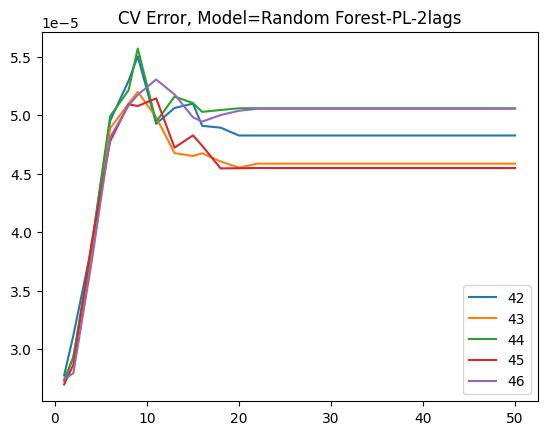

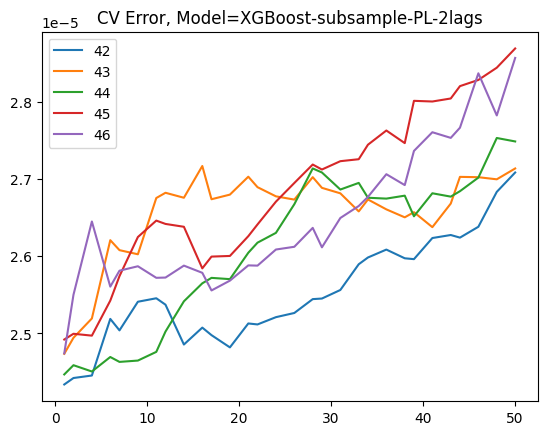

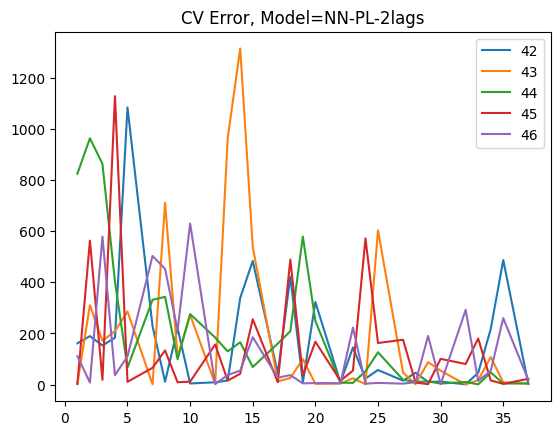

In [102]:
Models_seed_depend = ['Random Forest','XGBoost-subsample','NN']
Models_seed_depend2 = [s + '-PL-%ilags' %num_lags for s in Models_seed_depend]

for i, model in enumerate(Models_seed_depend2):
        query = """SELECT * FROM CV_error WHERE model='%s' and
        Transformation='%s' and Target='%s'""" %(model,Transformation,Target)
        RESULTS = pd.read_sql(query, con)
        idx = RESULTS.Tune_Param == 'CV_grid'
        grid = RESULTS[idx].iloc[0,7:].values
        val = RESULTS[~idx]
        legend_used = val.Seed
        val_used = val.iloc[:,7:].values.T
        if np.isin('None', grid):
                grid = [None if x=='None' else x for x in grid]
        plt.plot(grid,val_used)
        plt.legend(legend_used)
        plt.title('CV Error, Model=%s'%model)
        plt.show()


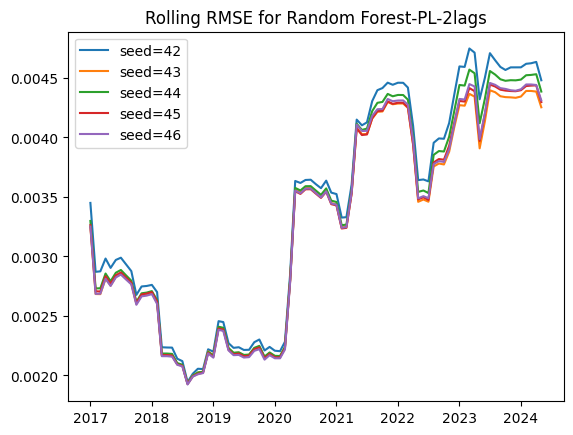

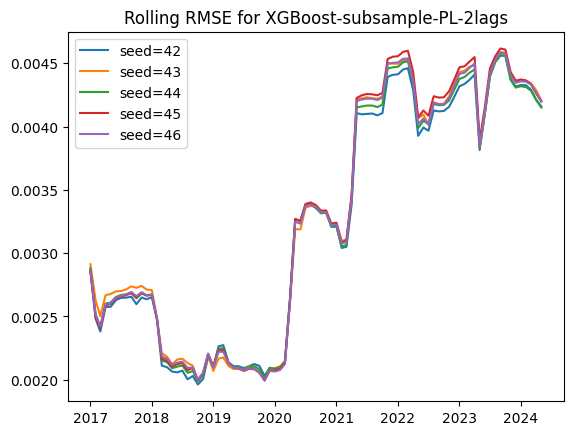

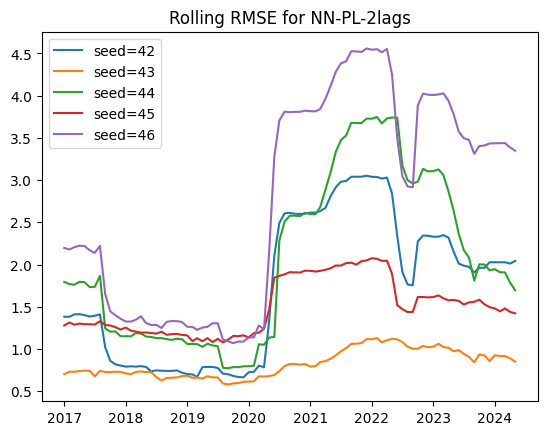

In [103]:
rolling_RMSE_pd = pd.Series(rolling_RMSE).reset_index()
rolling_RMSE_pd.columns = ['Model','seed','values']

for sd_md in seed_depend:
    plt.plot(pd.to_datetime(forecast_date[24:]),np.vstack(rolling_RMSE_pd.query("Model=='%s'"%sd_md)['values']).T)
    plt.title('Rolling RMSE for %s'%sd_md)
    plt.legend(['seed=%i'%sd for sd in seed_list])
    plt.show()

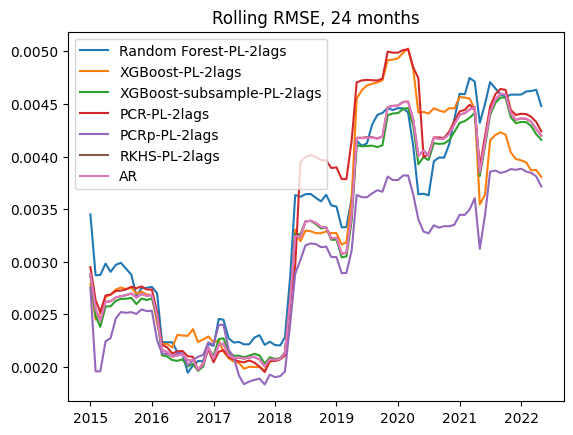

In [104]:
seed = 42
query_rst = rolling_RMSE_pd.query("seed==%i and Model!='NN-PL-%ilags'"%(seed,num_lags))

plt.plot(pd.to_datetime(forecast_date[:-24]),np.vstack(query_rst['values']).T)
plt.legend(query_rst['Model'])
plt.title('Rolling RMSE, 24 months')
plt.show()

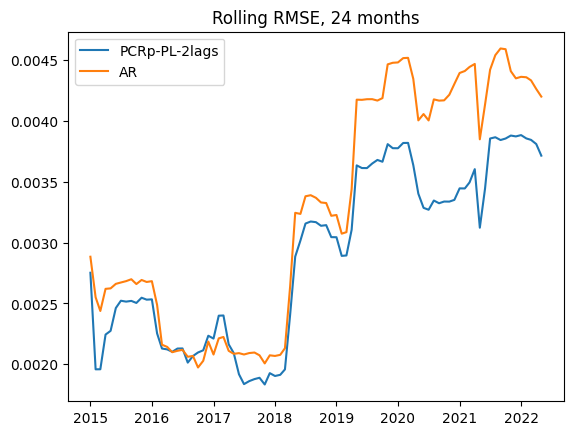

In [105]:
seed = 42
query_rst = rolling_RMSE_pd.query("seed==%i and Model!='NN-PL-%ilags'"%(seed,num_lags))
query_rst = query_rst.loc[np.isin(query_rst.Model, ['PCRp-PL-%ilags'%num_lags,'AR'])]
plt.plot(pd.to_datetime(forecast_date[:-24]),np.vstack(query_rst['values']).T)
plt.legend(query_rst['Model'])
plt.title('Rolling RMSE, 24 months')
plt.show()